# Online/batch actor-critic 구현

이번 장에서는 online actor-critic과 batch actor-critic 알고리즘을 `Pendulum-v1` 환경에 적용해볼 것이다. Batch actor-critic에서 배치 사이즈가 $N=1$인 경우가 online actor-critic이기 때문에 우리는 batch actor-critic을 구현하고 $N=1$일 때와 $N=64$일 때를 비교해볼 것이다. 지난 구현들과 겹치는 코드들은 따로 설명하지 않을 것이다. 먼저 필요한 패키지의 모듈들을 불러오자

In [1]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym
import matplotlib.pyplot as plt

from torch.distributions import Normal

<br>

___

## 정책 네트워크 및 상태 가치 네트워크 구현

REINFORCE with baseline에서 사용한 네트워크와 동일하다.

In [2]:
class MLPGaussianPolicy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=(512, ), activation_fn=F.relu):
        super(MLPGaussianPolicy, self).__init__()
        self.input_layer = nn.Linear(state_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i + 1]);
            self.hidden_layers.append(hidden_layer)
        self.mu_layer = nn.Linear(hidden_dims[-1], action_dim)
        self.log_std_layer = nn.Linear(hidden_dims[-1], action_dim)
        self.activation_fn = activation_fn

    def forward(self, x):
        x = self.activation_fn(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fn(hidden_layer(x))

        mu = self.mu_layer(x)
        log_std = torch.tanh(self.log_std_layer(x))

        return mu, log_std.exp()


class MLPStateValue(nn.Module):
    def __init__(self, state_dim, hidden_dims=(512, ), activation_fn=F.relu):
        super(MLPStateValue, self).__init__()
        self.input_layer = nn.Linear(state_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i + 1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], 1)
        self.activation_fn = activation_fn

    def forward(self, x):
        x = self.activation_fn(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fn(hidden_layer(x))
        x = self.output_layer(x)

        return x

<br>

___

## Batch actor-critic 구현

아래는 actor-critic 알고리즘을 구현한 것이다. 메서드별 상세한 설명은 클래스 정의 아래에 적어 놓았다.

In [3]:
class ActorCritic:
    def __init__(
        self,
        state_dim,
        action_dim,
        hidden_dims=(512, ),
        batch_size=32,
        activation_fn=F.relu,
        policy_lr=0.0003,
        value_lr=0.0003,
        gamma=0.99,
    ):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.policy = MLPGaussianPolicy(state_dim, action_dim, hidden_dims, activation_fn).to(self.device)
        self.value = MLPStateValue(state_dim, hidden_dims, activation_fn).to(self.device)        
        self.gamma = gamma
        self.batch_size = batch_size

        self.policy_optimizer = torch.optim.Adam(self.policy.parameters(), lr=policy_lr)
        self.value_optimizer = torch.optim.Adam(self.value.parameters(), lr=value_lr)
        
        self.buffer = []
    
    @torch.no_grad()
    def act(self, s, training=True):
        self.policy.train(training)

        s = torch.as_tensor(s, dtype=torch.float, device=self.device)
        mu, std = self.policy(s)
        z = torch.normal(mu, std) if training else mu
        action = torch.tanh(z)

        return action.cpu().numpy()
    
    def learn(self):
        self.policy.train()
        self.value.train()
        s, a, r, s_prime, _, terminated = map(np.stack, zip(*self.buffer))
        s, a, r, s_prime, done = map(
            lambda x: torch.as_tensor(x, dtype=torch.float, device=self.device),
            [s, a, r, s_prime, terminated]
        )
        r = r.unsqueeze(1)
        done = done.unsqueeze(1)

        # \pi(a|s) 로그 확률 값 계산하기
        mu, std = self.policy(s)
        m = Normal(mu, std)
        z = torch.atanh(torch.clamp(a, -1.0 + 1e-7, 1.0 - 1e-7))
        log_probs = m.log_prob(z)
        
        # 가치 네트워크 업데이트하기
        value = self.value(s)
        td_target = r + (1 - done) * self.gamma * self.value(s_prime)  # r + gamma V_{\phi}(s')
        value_loss = F.mse_loss(value, td_target.detach())  # td_target은 상수로 사용되기 때문에 detach() 해줘야 한다.
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()
        
        # 정책 네트워크 업데이트
        policy_loss = -(log_probs * (td_target - value).detach()).mean()
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

        result = {'policy_loss': policy_loss.item(), 'value_loss': value_loss.item()}

        return result
    
    def step(self, transition):
        result = None
        self.buffer.append(transition)
        if len(self.buffer) > self.batch_size:
            result = self.learn()
            self.buffer = []

        return result
        

<br>

- `__init__()` 메서드는 몇 번의 상호작용마다 네트워크들을 업데이트할지를 결정하는 `batch_size` 인자가 추가된 것 외에는 REINFORCE with baseline과 동일하다. 
- `act()` 메서드도 continuous action의 경우만 구현했다는 차이가 있을 뿐 REINFORCE with baseline과 동일하다.
- `step()` 메서드는 환경과 1번 상호작용할 때마다 에이전트가 하는 행동을 정의해놓은 메서드이다. REINFORCE with baseline 구현에서 `process()` 메서드에 대응하는 메서드인데, 필자의 변덕으로 인해 이름이 `step()`으로 변경됐다. REINFORCE with baseline에서는 매 스탭마다 데이터를 `buffer`라는 리스트에 추가해주었다. 그리고 에피소드가 종료되었다면 `self.learn()`을 호출하여 네트워크를 업데이트해줬었다.
~~~python
# REINFORCE with baseline의 process() 메서드
def process(self, transition):
    result = None
    self.buffer.append(transition)
    if transition[-1] or transition[-2]:
        result = self.learn()
        self.buffer = []
    return result
~~~

<br>

- Batch actor-critic의 경우 매 `batch_size` 스탭마다 `self.learn()`을 호출해주면 된다.
~~~python
#  Batch actor-critic의 step() 메서드
def step(self, transition):
    result = None
    self.buffer.append(transition)
    if len(self.buffer) > self.batch_size:
        result = self.learn()
        self.buffer = []

    return result
~~~

<br>

- `learn()` 메서드에서는 가치 네트워크와 정책 네트워크를 업데이트할 때 사용되는 타겟값이 달라진다. REINFORCE with baseline에서는 각 시점 $t$에 대응하는 $G_t$를 계산하여 가치 네트워크와 정책 네트워크를 업데이트했다. Actor-critic 알고리즘에서는 $G_t$ 대신 $r_t + \gamma V_{\phi}(s_{t+1})$을 계산한다. 이는 `td_target` 변수에 정의되어 있으며 temporal difference target이라는 뜻이다. $t$시점의 상태 $s_t$에 대한 가치 네트워크의 타겟값이 다음 시점의 상태 $s_{t+1}$에 의존적이기 때문에 붙여진 이름이다.
~~~python
value = self.value(s)
td_target = r + (1 - done) * self.gamma * self.value(s_prime)  # r + gamma V_{\phi}(s')
value_loss = F.mse_loss(value, td_target.detach())  # td_target은 상수로 사용되기 때문에 detach() 해줘야 한다.
self.value_optimizer.zero_grad()
value_loss.backward()
self.value_optimizer.step()
~~~
- 구현 디테일로는 `td_target`을 계산할 때 들어가는 `(1 - done)`이다. 만약 다음 상태인 `s_prime`이 마지막 상태라면, 마지막 상태 이후로는 에피소드가 진행이 되지 않기 때문에 보상을 받지 않을 것이다. 따라서 마지막 상태의 가치함수는 0이 된다. 이를 반영하기 위하여 `(1 - done)`을 곱해주어 만약 `done`이 True이면, 즉 에피소드가 종료되었다면 0을 곱해주어 가치함수텀을 없애주는 것이다. 
- 두 번째 구현 디테일로는 `value_loss`를 계산할 때, 레이블로 사용되는 `td_target`의 경우 `self.value(s_prime)`텀을 포함하고 있기 때문에 가치 네트워크의 파라미터가 포함되어 있다. `td_target`은 레이블로서 사용되는 것이고 `value_loss`를 줄이는 데 사용되는 것이 아니기 때문에 `detach()` 메서드를 통해 그레디언트를 계산 과정을 computational graph에서 제거해준다.

<br>

- 정책 네트워크 또한 $(G_t - V_{\phi}(s_t)) \nabla \pi (a_t|s_t)$ 대신 $(r_t + \gamma V_{\phi}(s_{t+1}) - V_{\phi}(s_t)) \nabla \pi (a_t|s_t)$을 통해 업데이트해준다. 마찬가지로 `td_target - value`는 상수로서 사용되기 때문에 `detach()` 메서드를 사용했다. 사실 `policy loss`는 `policy_optimizer`로만 줄이기 때문에 가치 네트워크 파라미터는 업데이트가 되지 않지만 필자는 혹시 몰라서 붙이는 편이다.
~~~python
# 정책 네트워크 업데이트
policy_loss = -(log_probs * (td_target - value).detach()).mean()
self.policy_optimizer.zero_grad()
policy_loss.backward()
self.policy_optimizer.step()
~~~

<br>


<br>

___

## Actor-critic 에이전트 훈련

이후 코드는 REINFORCE와 REINFORCE with baseline와 동일하다. 네트워크 구조는 이전과 살짝 다른데, 나중에 구현할 PPO와 비슷하게 만들어 놓았다.

In [4]:
def evaluate(env_name, agent, eval_iterations):
    env = gym.make(env_name)
    scores = []
    for _ in range(eval_iterations):
        (s, _), terminated, truncated, score = env.reset(seed=np.random.randint(10000)), False, False, 0
        while not (terminated or truncated):
            a = agent.act(s, training=False)
            s_prime, r, terminated, truncated, _ = env.step(2.0 * a)
            score += r
            s = s_prime
        scores.append(score)
    env.close()
    return round(np.mean(scores), 4)

<br> 

실험의 재현성과 알고리즘 사이의 동등한 비교를 위하여 다음과 같이 랜덤 시드를 설정해주는 `seed_all` 함수를 정의해주었다.
각 알고리즘 실험을 시작하기 전에 `seed_all()` 함수를 실행해주면, 두 실험의 네트워크 파라미터들이 동일하게 초기화되며, 환경 초기화 등 환경에 내재된 무작위성도 모두 동일한 순서로 발생한다. 그리고 코드를 실행할 때마다 같은 결과를 얻게 해준다 (연산 장비에 따라서는 달라질 수 있다).

In [10]:
def seed_all(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


<br>

### Batch actor-critic
$N=64$일 때 batch actor-critic 훈련 코드이다. 매 64번의 상호작용마다 네트워크 업데이트가 이뤄진다.

In [6]:
%%time
env_name = 'Pendulum-v1'

seed = 0
seed_all(seed)
hidden_dims = (64, 64, )
max_iterations = 1000000
eval_intervals = 5000
eval_iterations = 10
batch_size = 64
gamma = 0.95

env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
agent = ActorCritic(state_dim, action_dim, hidden_dims=hidden_dims, gamma=gamma, batch_size=batch_size)

logger = []
(s, _), terminated, truncated = env.reset(), False, False
for t in range(1, max_iterations + 1):
    a = agent.act(s)
    s_prime, r, terminated, truncated, _ = env.step(2.0 * a)
    result = agent.step((s, a, r, s_prime, terminated, truncated))
    s = s_prime
    
    if result is not None:
        logger.append([t, 'policy_loss', result['policy_loss']])
        logger.append([t, 'value_loss', result['value_loss']])
    
    if terminated or truncated:
        (s, _), terminated, truncated = env.reset(), False, False
        
    if t % eval_intervals == 0:
        score = evaluate(env_name, agent, eval_iterations)
        logger.append([t, 'Avg return', score])

CPU times: user 8min 44s, sys: 887 ms, total: 8min 44s
Wall time: 8min 44s


<br>

아래는 학습 결과 시각화이다. 사실 이 한 번의 실험만으로 REINFORCE with baseline이 더 좋은지 actor-critic이 더 좋은지 결정할 수는 없다.
진정한 비교를 위해서는 각 알고리즘을 적게는 5회, 중간 횟수로는 10회, 많게는 30회 돌려서 스탭당 성능의 기댓값으로 비교를 해봐야 한다.


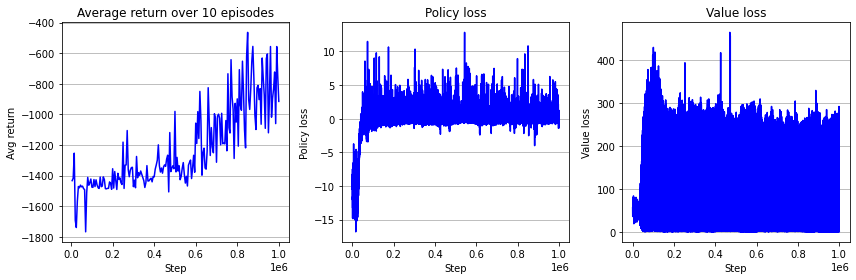

In [7]:
logger = pd.DataFrame(logger)
logger.columns = ['step', 'key', 'value']

fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 3, 1)
key = 'Avg return'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Average return over 10 episodes")
ax.set_xlabel("Step")
ax.set_ylabel("Avg return")

ax = fig.add_subplot(1, 3, 2)
key = 'policy_loss'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Policy loss")
ax.set_xlabel("Step")
ax.set_ylabel("Policy loss")

ax = fig.add_subplot(1, 3, 3)
key = 'value_loss'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Value loss")
ax.set_xlabel("Step")
ax.set_ylabel("Value loss")

fig.tight_layout()
plt.show()

<br>

### Online actor-critic
$N=1$일 때 online actor-critic 훈련 코드이다. 매 스탭마다 네트워크 업데이트가 이뤄지기 때문에 학습이 끝날 때까지 시간이 많이 소요된다.

In [ ]:
%%time
env_name = 'Pendulum-v1'

seed = 0
seed_all(seed)
hidden_dims = (64, 64, )
max_iterations = 1000000
eval_intervals = 5000
eval_iterations = 10
batch_size = 1
gamma = 0.95

env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
agent = ActorCritic(state_dim, action_dim, hidden_dims=hidden_dims, gamma=gamma, batch_size=batch_size)

logger = []
(s, _), terminated, truncated = env.reset(), False, False
for t in range(1, max_iterations + 1):
    a = agent.act(s)
    s_prime, r, terminated, truncated, _ = env.step(2.0 * a)
    result = agent.step((s, a, r, s_prime, terminated, truncated))
    s = s_prime
    
    if result is not None:
        logger.append([t, 'policy_loss', result['policy_loss']])
        logger.append([t, 'value_loss', result['value_loss']])
    
    if terminated or truncated:
        (s, _), terminated, truncated = env.reset(), False, False
        
    if t % eval_intervals == 0:
        score = evaluate(env_name, agent, eval_iterations)
        logger.append([t, 'Avg return', score])

CPU times: user 32min 12s, sys: 8.85 s, total: 32min 21s
Wall time: 32min 18s


<br>

8분 밖에 소요되지 않았던 batch actor-critic과 달리 online actor-critic은 32분이 소요되었다. 매 스탭마다 그레디언트 역전파 및 파라미터 업데이트가 일어나기 때문이다. 그리고 한 번의 실험만으로 단정할 수 없지만, 같은 무작위성 아래에서 online actor-critic은 환경 제어에 완전히 실패했다. 가장 큰 이유로는 정책 네트워크와 가치 네트워크의 손실값이 발산한 것이 있을 것이다. 아무래도 데이터 1개만으로 policy gradient를 추정하다보니 추정치의 분산이 굉장히 클 것이다. 실제 그레디언트와 많이 차이나는 추정치도 있을 것이다.


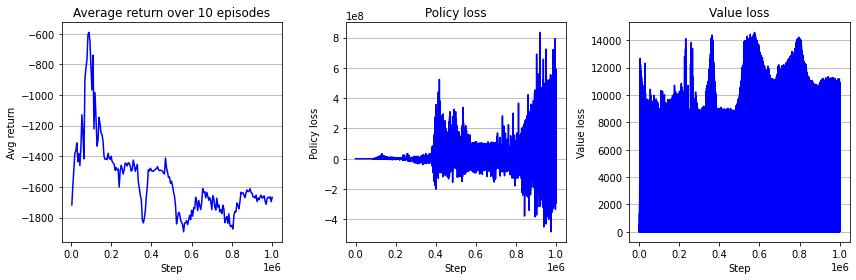

In [9]:
logger = pd.DataFrame(logger)
logger.columns = ['step', 'key', 'value']

fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 3, 1)
key = 'Avg return'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Average return over 10 episodes")
ax.set_xlabel("Step")
ax.set_ylabel("Avg return")

ax = fig.add_subplot(1, 3, 2)
key = 'policy_loss'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Policy loss")
ax.set_xlabel("Step")
ax.set_ylabel("Policy loss")

ax = fig.add_subplot(1, 3, 3)
key = 'value_loss'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Value loss")
ax.set_xlabel("Step")
ax.set_ylabel("Value loss")

fig.tight_layout()
plt.show()

<br>

이것으로 actor-critic 구현을 마치도록 하겠다. 다음 주제로는 네트워크 업데이트에 사용되는 타겟값 $G_t$ 또는 $r_t + \gamma V_{\phi}(s_{t+1})$의 중간 지점에 있는 $n$-step return과 모든 $n$-step return을 가중평균하는 Generalized Advantage Estimation (GAE)에 대해서 알아볼 것이다.

<br>

```{raw} html
<script
   type="text/javascript"
   src="https://utteranc.es/client.js"
   async="async"
   repo="HiddenBeginner/Deep-Reinforcement-Learnings"
   issue-term="pathname"
   theme="github-light"
   label="💬 comment"
   crossorigin="anonymous"
/>
```